## Columns
- price price in US dollars (\$326--\$18,823) 
- carat weight of the diamond (0.2--5.01)
- cut quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- color diamond colour, from J (worst) to D (best)
- clarity a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
- x length in mm (0--10.74)
- y width in mm (0--58.9)
- z depth in mm (0--31.8)
- depth total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
- table width of top of diamond relative to widest point (43--95)

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Reading the data

In [3]:
D_Train=pd.read_csv("dataset/train.csv")
D_Train.drop(labels=['Id'], axis=1,inplace=True)

In [4]:
D_Train.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.06,Ideal,I,SI2,61.8,57.0,4270,6.57,6.60,4.07
1,1.51,Premium,G,VVS2,60.9,58.0,15164,7.38,7.42,4.51
2,0.32,Ideal,F,VS2,61.3,56.0,828,4.43,4.41,2.71
3,0.53,Ideal,G,VS2,61.2,56.0,1577,5.19,5.22,3.19
4,0.70,Premium,H,VVS2,61.0,57.0,2596,5.76,5.72,3.50


<div style="float:left">
    <h3> carat </h3>
<img src= "https://cdn.loosegrowndiamond.com/wp-content/uploads/2022/02/different-carat-sizes.png" alt="carat image" width="450" height="500"></div>

<div style="float:right">
    <h3> cut </h3>
<img src= "https://cdn.shopify.com/s/files/1/0403/0762/2040/files/diamond-chart-cut_2_1024x1024.jpg?v=1617401955" alt="cut image" width="450" height="500"></div>

<div style="float:left">
    <h3> clarity </h3>
<img src= "https://assets-rarecarat.s3.amazonaws.com/images/blog/clarity-chart.jpg" alt="cut image" width="450" height="500"></div>

<div style="float:right">
    <h3> color </h3>
<img src= "https://www.brides.com/thmb/GBtDWdJwsYmu17LqrVGm2lR49nU=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/diamond-color-chart-5093397_horizontal-b8d3872096fd47c78d244d40cc920099.png" alt="color image" width="450" height="500"></div>


### Take a Quick Look at the Data Structure

In [5]:
D_Train.shape

(43152, 10)

> We have `43152` records and `11` Features

In [6]:
D_Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43152 entries, 0 to 43151
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    43152 non-null  float64
 1   cut      43152 non-null  object 
 2   color    43152 non-null  object 
 3   clarity  43152 non-null  object 
 4   depth    43152 non-null  float64
 5   table    43152 non-null  float64
 6   price    43152 non-null  int64  
 7   x        43152 non-null  float64
 8   y        43152 non-null  float64
 9   z        43152 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.3+ MB


> normal data types and the data doesn't have any null values

In [7]:
D_Train.describe()

,carat,depth,table,price,x,y,z
count,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000
mean,0.797855,61.747177,57.458347,3929.491912,5.731568,5.735018,3.538568
std,0.473594,1.435454,2.233904,3985.527795,1.121279,1.148809,0.708238
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,947.750000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5312.000000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


> abnormal values in `x`,`y` and `z` columns min = 0

In [8]:
D_Train.median(numeric_only= True)

carat       0.70
depth      61.80
table      57.00
price    2401.00
x           5.70
y           5.71
z           3.53
dtype: float64

> may be there are some outliers values in `price` column

# Cleaning the data (null and duplicated values)

In [9]:
D_Train.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [10]:
D_Train.isna().sum().sum()

0

In [11]:
D_Train.drop_duplicates(inplace= True)

In [12]:
cat_cols= D_Train.columns[1:4]
num_cols= D_Train.columns[4:].insert(0, D_Train.columns[0])
print(cat_cols)
print(num_cols)

Index(['cut', 'color', 'clarity'], dtype='object')
Index(['carat', 'depth', 'table', 'price', 'x', 'y', 'z'], dtype='object')


In [13]:
for cat_col in cat_cols:
    print(cat_col+ "\n"+ str(D_Train[cat_col].value_counts(normalize= True) * 100) + "\n")

cut
Ideal        39.858321
Premium      25.734526
Very Good    22.415515
Good          8.997794
Fair          2.993845
Name: cut, dtype: float64

color
G    21.001045
E    18.155847
F    17.689002
H    15.396586
D    12.567646
I     9.880386
J     5.309488
Name: color, dtype: float64

clarity
SI1     24.169086
VS2     22.775520
SI2     17.194286
VS1     15.015678
VVS2     9.362443
VVS1     6.733248
IF       3.344559
I1       1.405179
Name: clarity, dtype: float64



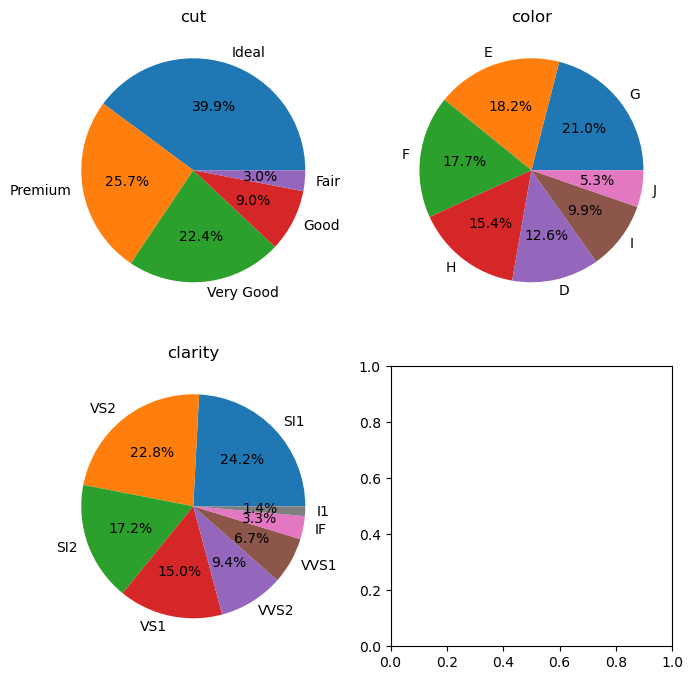

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))
c,r= 0, 0
for cat_col in cat_cols:
    x= D_Train[cat_col].value_counts()

    axes[r, c].pie(x, labels= x.index, autopct= '%1.1f%%')
    axes[r, c].set_title(cat_col)
    c= c + 1
    if c == 2:
        r= r + 1
        c= 0

    
plt.show()

> the data is unbalanced, <br>Ideal cut is 39.87% of `cut` column and fair is only 3%, <br>G is 21.00 % of `color` column and j is only 5.31%<br>SI1 is 24.17% of `clarity` column and I1 is only 1.40%

# Discover and Visualize the Data to Gain Insights

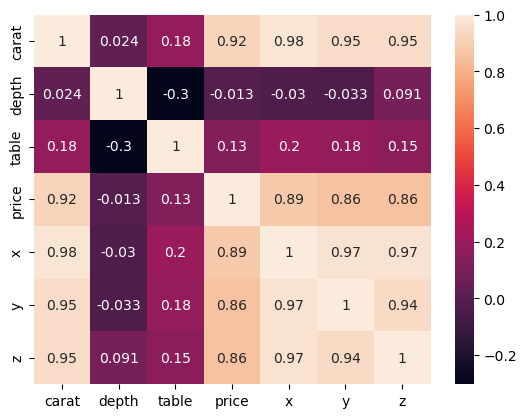

In [15]:
df_corr= D_Train.corr()
sns.heatmap(df_corr, annot= True)
plt.show()

> there are a strong linear relation between (`carat`, `x`, `y`, `z`) columns and `price` column

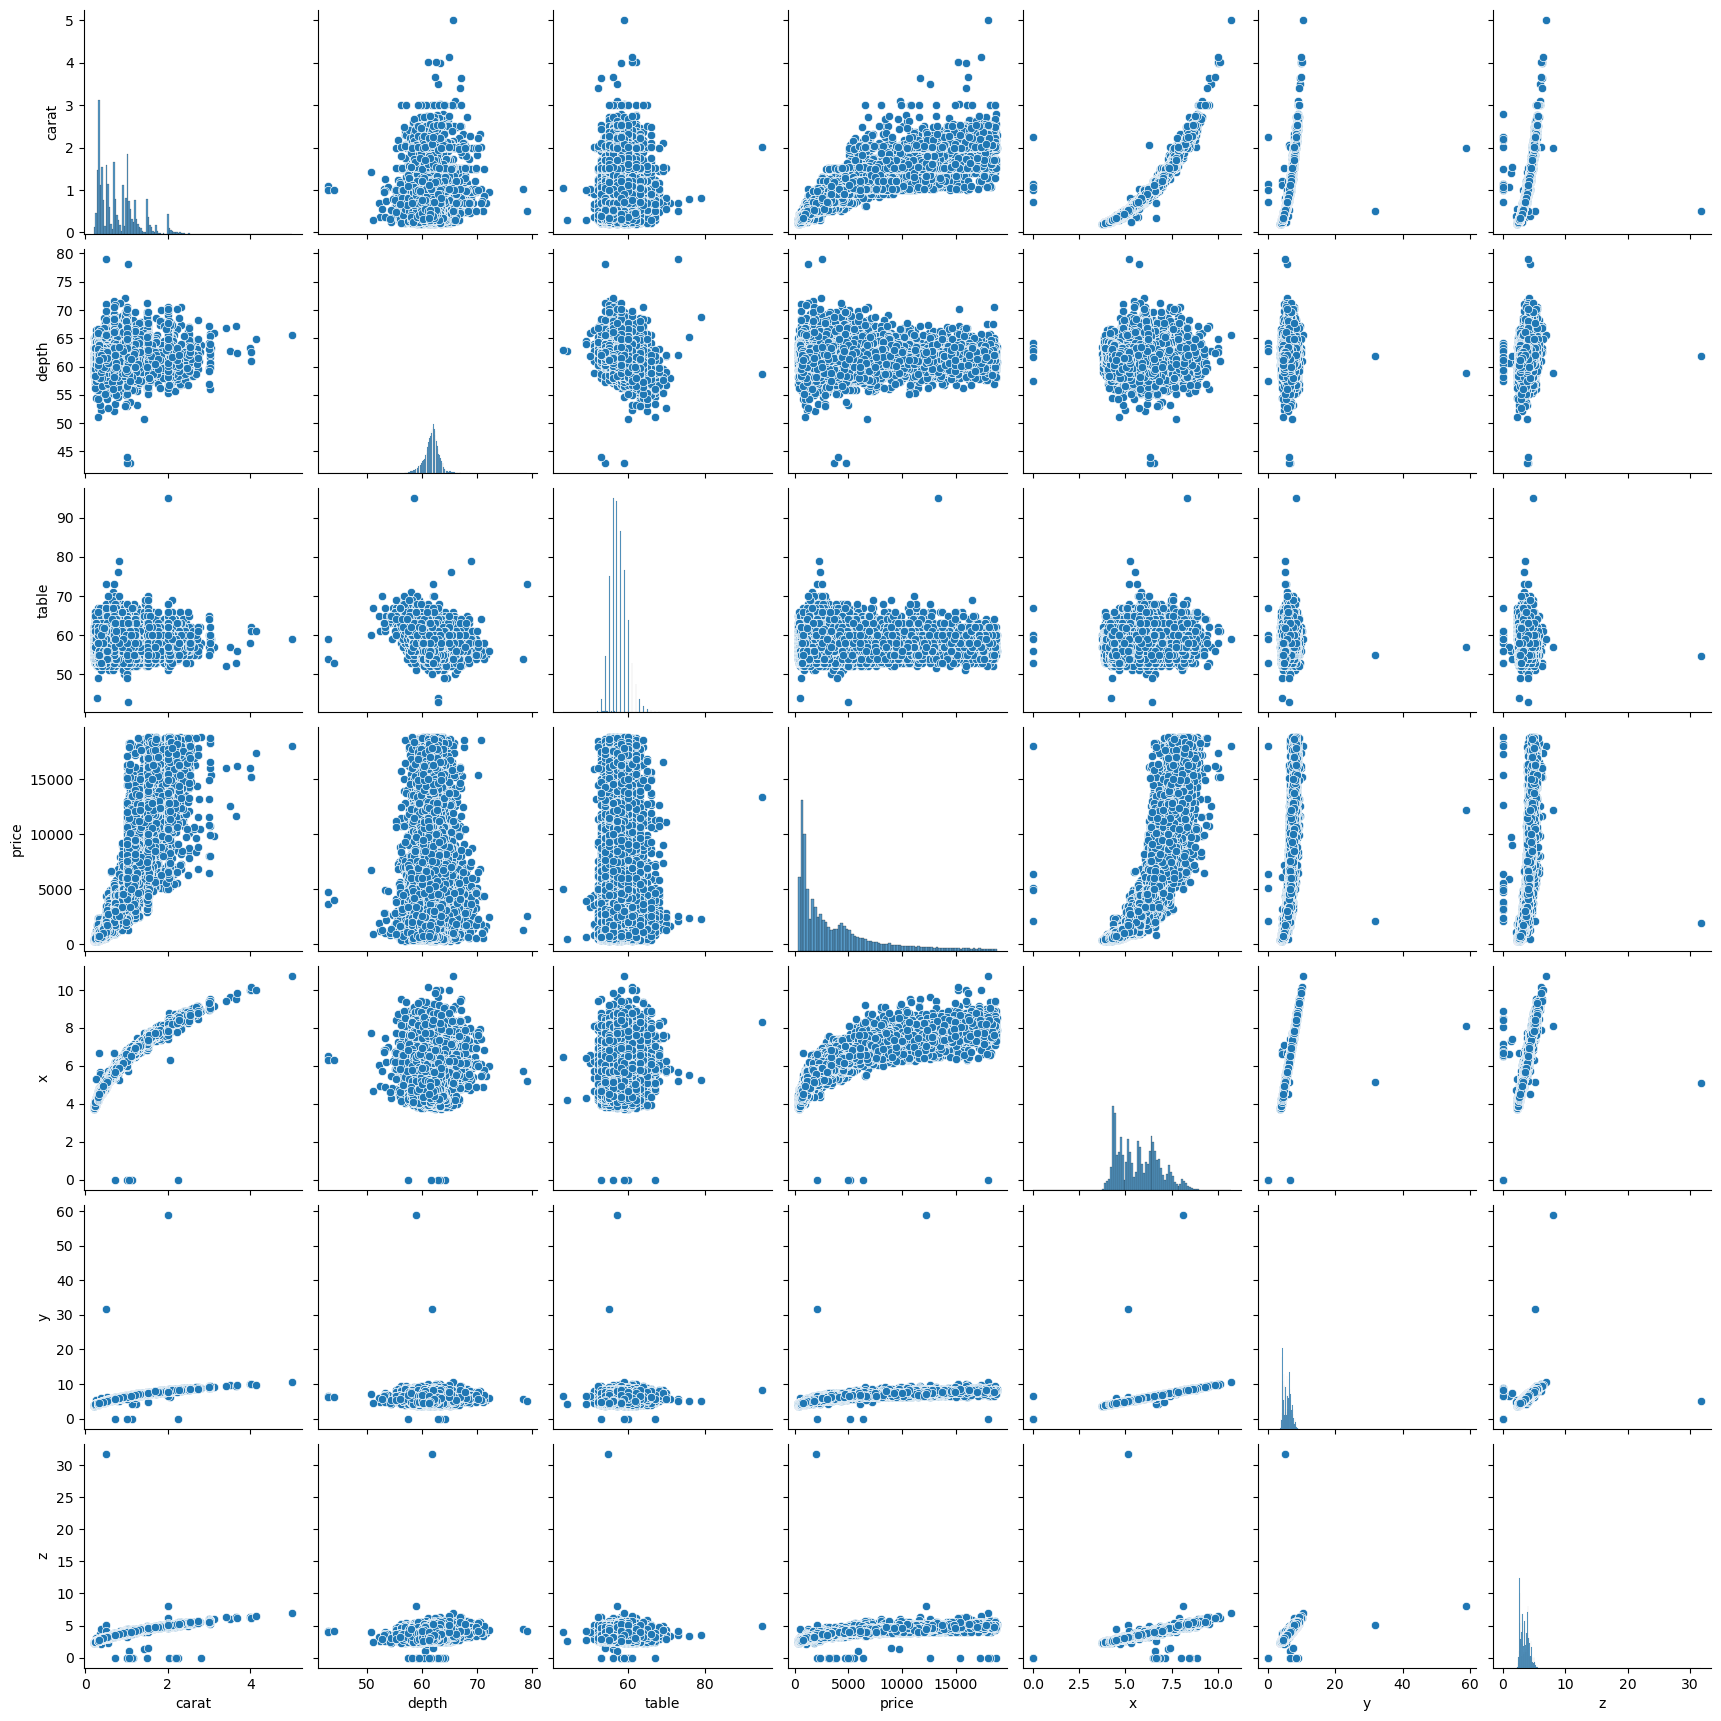

In [16]:
sns.pairplot(D_Train)
plt.show()

> some columns values take curved shape

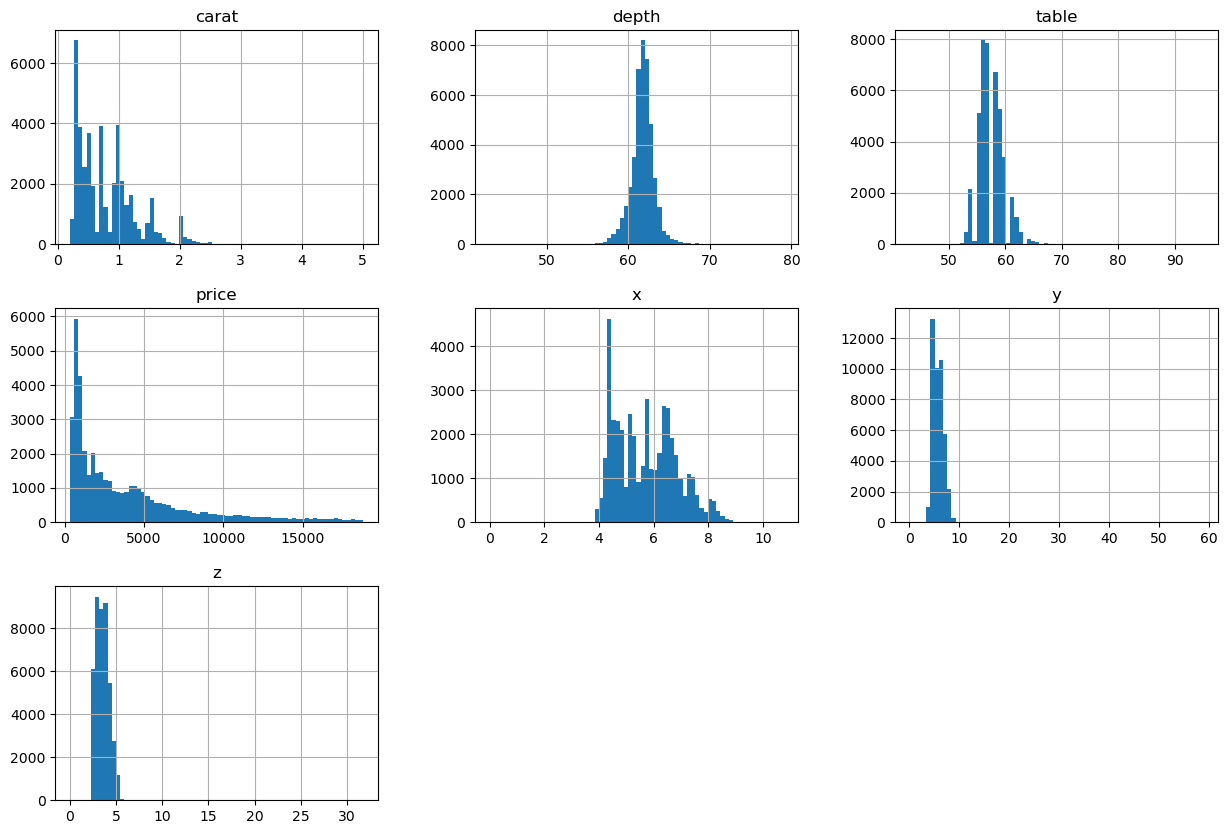

In [17]:
D_Train.hist(bins= 70, figsize=(15, 10))
plt.show()

> the data has outliers. `depth`, `table`, `y` and `x` columns are normaly distributed. other columns is positive (left) skewed

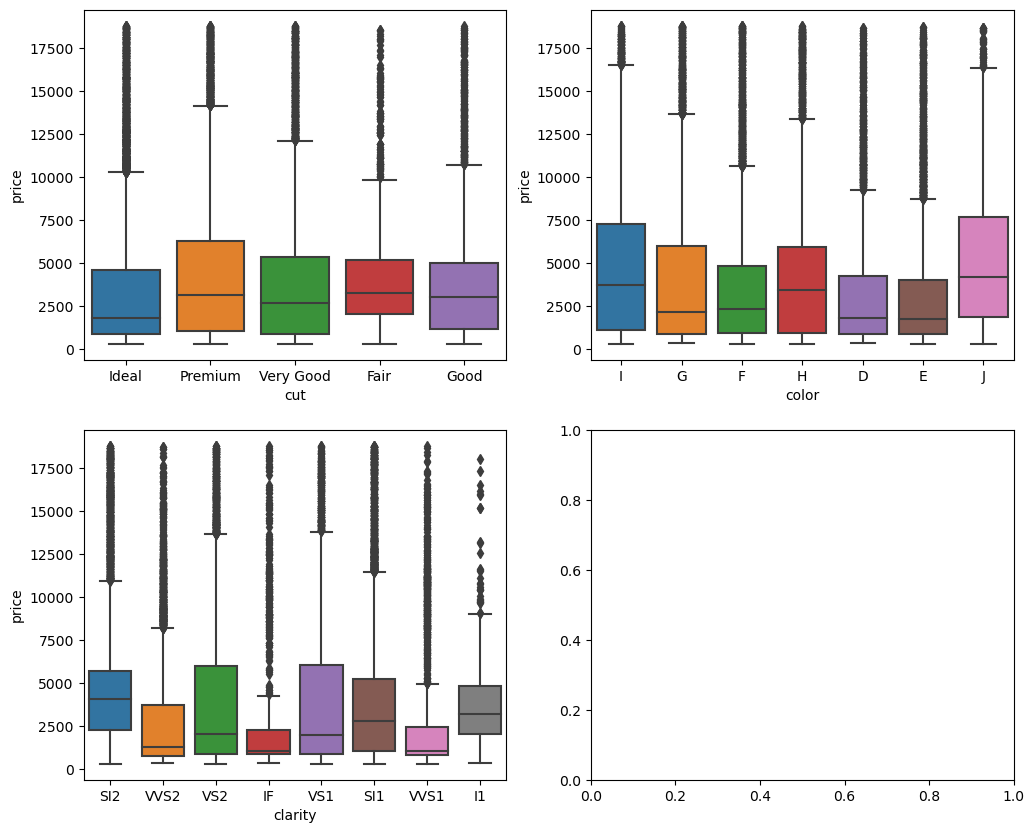

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))
r, c =0, 0
for cat_col in cat_cols:
    sns.boxplot(ax=axes[r, c], data=D_Train, y='price', x= D_Train[cat_col])
    c= c + 1
    if c == 2:
        r= r + 1
        c= 0
    
plt.show()

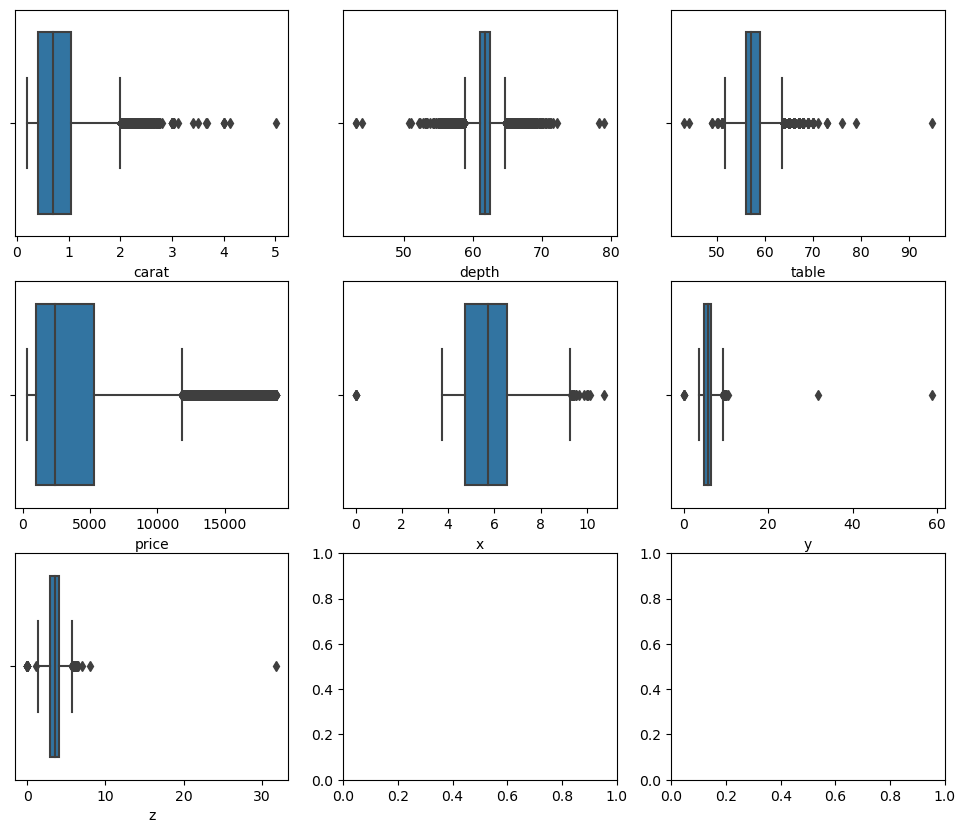

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(12,10))
r, c =0, 0
for num_col in num_cols:
    sns.boxplot(ax=axes[r, c], x= D_Train[num_col] )
    c= c + 1
    if c == 3:
        r= r + 1
        c= 0
    
plt.show()

### Handel outliers

In [20]:
print(f"rows= {D_Train.shape[0]}")
zero_df= D_Train[(D_Train['x'] == 0) | (D_Train['y'] == 0) | (D_Train['z'] <= 1.07)]
D_Train.drop(zero_df.index, inplace= True)
print(f"rows= {D_Train.shape[0]}")

rows= 43055
rows= 43037


In [21]:
D_Train.nlargest(5, "x")

,carat,cut,color,clarity,depth,table,price,x,y,z
26886,5.01,Fair,J,I1,65.5,59.0,18018,10.74,10.54,6.98
26030,4.01,Premium,I,I1,61.0,61.0,15223,10.14,10.10,6.17
18840,4.01,Premium,J,I1,62.5,62.0,15223,10.02,9.94,6.24
7389,4.00,Very Good,I,I1,63.3,58.0,15984,10.01,9.94,6.31
31151,4.13,Fair,H,I1,64.8,61.0,17329,10.00,9.85,6.43


In [22]:
D_Train.nlargest(5, "y")

,carat,cut,color,clarity,depth,table,price,x,y,z
35359,2.00,Premium,H,SI2,58.9,57.0,12210,8.09,58.90,8.06
40663,0.51,Ideal,E,VS1,61.8,55.0,2075,5.15,31.80,5.12
26886,5.01,Fair,J,I1,65.5,59.0,18018,10.74,10.54,6.98
26030,4.01,Premium,I,I1,61.0,61.0,15223,10.14,10.10,6.17
7389,4.00,Very Good,I,I1,63.3,58.0,15984,10.01,9.94,6.31


In [23]:
D_Train.nlargest(5, "z")

,carat,cut,color,clarity,depth,table,price,x,y,z
10541,0.51,Very Good,E,VS1,61.8,54.7,1970,5.12,5.15,31.80
35359,2.00,Premium,H,SI2,58.9,57.0,12210,8.09,58.90,8.06
26886,5.01,Fair,J,I1,65.5,59.0,18018,10.74,10.54,6.98
31151,4.13,Fair,H,I1,64.8,61.0,17329,10.00,9.85,6.43
16302,3.65,Fair,H,I1,67.1,53.0,11668,9.53,9.48,6.38


In [24]:
print(f"rows= {D_Train.shape[0]}")
largest_df= D_Train[(D_Train['x'] == 10.74) | (D_Train['y'] >= 31.80) | (D_Train['z'] == 31.80)]
D_Train.drop(largest_df.index, inplace= True)
print(f"rows= {D_Train.shape[0]}")

rows= 43037
rows= 43033


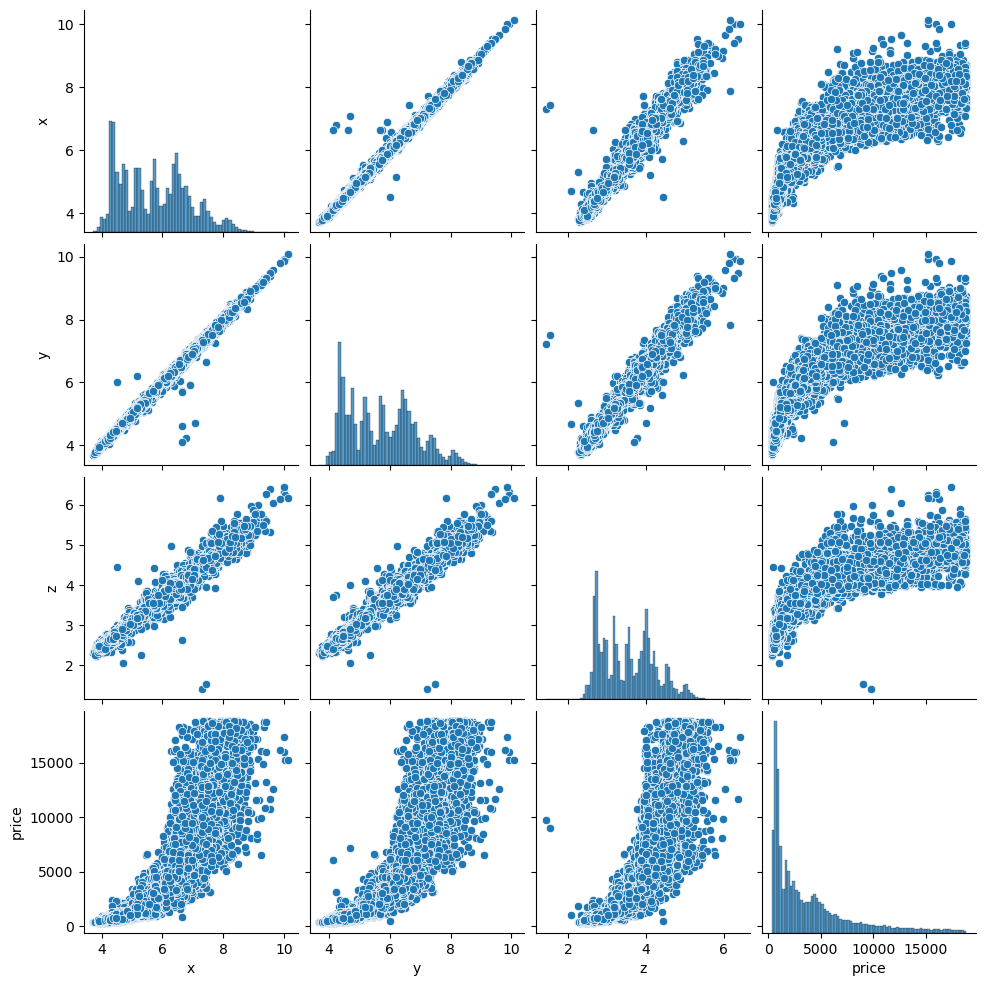

In [25]:
sns.pairplot(D_Train[['x', 'y', 'z', 'price']])
plt.show()

> also x, y, z columns are curved

# Prepare the data for ML.  

## Combining x,y,z with one column called size

In [26]:
D_Train['size']=D_Train['x']*D_Train['y']*D_Train['z']
D_Train.drop(labels=['x','y','z'], axis=1,inplace=True)
D_Train.head()

,carat,cut,color,clarity,depth,table,price,size
0,1.06,Ideal,I,SI2,61.8,57.0,4270,176.483340
1,1.51,Premium,G,VVS2,60.9,58.0,15164,246.965796
2,0.32,Ideal,F,VS2,61.3,56.0,828,52.943373
3,0.53,Ideal,G,VS2,61.2,56.0,1577,86.422842
4,0.70,Premium,H,VVS2,61.0,57.0,2596,115.315200


In [27]:
D_Train_num =D_Train.select_dtypes(include=[np.number])

## Getting Standard Scaler

In [28]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
D_Train_num_std_scaled = std_scaler.fit_transform(D_Train_num)
print(D_Train_num_std_scaled[:,0])

[ 0.55589296  1.50832978 -1.01033647 ... -0.75635332 -1.03150174
 -0.98917121]


In [29]:
D_Train_cat=D_Train[["cut",'color',"clarity"]] 

## Getting OrdinalEncoder to encode categorical values

In [30]:
from sklearn.preprocessing import OrdinalEncoder
categories = [
    ['Ideal','Premium','Very Good','Good','Fair'],
    ['D','E','F','G','H','I','J'],
    ['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2','I1']
]

ordinal_encoder = OrdinalEncoder(categories=categories)
D_Train_encoded=ordinal_encoder.fit_transform(D_Train_cat)




In [31]:
print(ordinal_encoder.categories_)

[array(['Ideal', 'Premium', 'Very Good', 'Good', 'Fair'], dtype=object), array(['D', 'E', 'F', 'G', 'H', 'I', 'J'], dtype=object), array(['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1'],
      dtype=object)]


## Splitting the data into test and train sets

In [32]:
from sklearn.model_selection import train_test_split
train_set,test_set= train_test_split(D_Train, test_size=0.2, random_state=42)

## Putting the modifications we made to the data into a pipeline

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

Diamond=train_set.drop("price",axis=1)
Diamond_labels=train_set['price'].copy()
X_test=test_set.drop("price",axis=1)
Y_test=test_set['price'].copy()
Diamond_num = Diamond.drop(['cut','color','clarity'], axis=1)
num_attribs=list(Diamond_num)
cat_attribs = ['cut','color','clarity']
num_pipeline = Pipeline([
 ('std_scaler', StandardScaler())])

full_pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attribs),
 ("cat", ordinal_encoder, cat_attribs)])
Diamond_prepared = full_pipeline.fit_transform(Diamond)

# Select a model and train it.

# Linear Regression

In [34]:
rmse_all= {}

In [35]:
from sklearn.linear_model import LinearRegression

lr_model= make_pipeline(full_pipeline, LinearRegression())
lr_model.fit(Diamond, Diamond_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'size']),
                                                 ('cat',
                                                  OrdinalEncoder(categories=[['Ideal',
                                                                              'Premium',
                                                                              'Very '
                                                                              'Good',
                                                                              'Good',
                                                                              'Fair'],
                   

In [36]:
y_pred_lr= lr_model.predict(X_test)
lr_rmse = mean_squared_error(Y_test, y_pred_lr, squared=False)
rmse_all["lr"] = lr_rmse
lr_rmse

1244.645944235713

## Polynomial Regression

In [37]:
from sklearn.preprocessing import PolynomialFeatures

poly_features= make_pipeline(full_pipeline, PolynomialFeatures(degree = 2))
X_poly= poly_features.fit_transform(Diamond, Diamond_labels)

In [38]:
poly_model= LinearRegression()
poly_model.fit(X_poly, Diamond_labels)

LinearRegression()

In [39]:
poly_test= make_pipeline(full_pipeline, PolynomialFeatures(degree = 2))
x_test_poly= poly_test.fit_transform(X_test)

y_pred_poly= poly_model.predict(x_test_poly)
poly_rmse = mean_squared_error(Y_test, y_pred_poly, squared=False)
rmse_all["poly"] = poly_rmse
poly_rmse

881.8013253044685

## SVM

In [40]:
from sklearn.svm import SVR 

svr_model = make_pipeline(full_pipeline,SVR(kernel='poly', degree= 2))
svr_model.fit(Diamond, Diamond_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'size']),
                                                 ('cat',
                                                  OrdinalEncoder(categories=[['Ideal',
                                                                              'Premium',
                                                                              'Very '
                                                                              'Good',
                                                                              'Good',
                                                                              'Fair'],
                   

In [41]:
y_pred_svr=svr_model.predict(X_test)
svr_rmse = mean_squared_error(Y_test, y_pred_svr, squared=False)
rmse_all["svr"] = svr_rmse
svr_rmse

2498.330639184574

## Random Forest

In [42]:
from sklearn.ensemble import RandomForestRegressor

rand_forest_model = make_pipeline(full_pipeline,RandomForestRegressor(n_estimators=100, random_state=42))
rand_forest_model.fit(Diamond, Diamond_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'size']),
                                                 ('cat',
                                                  OrdinalEncoder(categories=[['Ideal',
                                                                              'Premium',
                                                                              'Very '
                                                                              'Good',
                                                                              'Good',
                                                                              'Fair'],
                   

In [43]:
y_pred_rand_forest=rand_forest_model.predict(X_test)
rand_forest_rmse = mean_squared_error(Y_test, y_pred_rand_forest, squared=False)
rmse_all["rand_forest"] = rand_forest_rmse
rand_forest_rmse

561.1460742050482

## XGboost

In [44]:
XGB_model = make_pipeline(full_pipeline,XGBRegressor())
XGB_model.fit(Diamond, Diamond_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'size']),
                                                 ('cat',
                                                  OrdinalEncoder(categories=[['Ideal',
                                                                              'Premium',
                                                                              'Very '
                                                                              'Good',
                                                                              'Good',
                                                                              'Fair'],
                   

In [45]:
y_pred_XGB=XGB_model.predict(X_test)
xgb_rmse = mean_squared_error(Y_test, y_pred_XGB, squared=False)
rmse_all["XGboost"] = xgb_rmse
xgb_rmse

557.9927356583727

## Gradient Boosting

In [48]:
from sklearn.ensemble import GradientBoostingRegressor

gbm_model = make_pipeline(full_pipeline,GradientBoostingRegressor())
gbm_model.fit(Diamond, Diamond_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'size']),
                                                 ('cat',
                                                  OrdinalEncoder(categories=[['Ideal',
                                                                              'Premium',
                                                                              'Very '
                                                                              'Good',
                                                                              'Good',
                                                                              'Fair'],
                   

In [51]:
y_pred_gbm=gbm_model.predict(X_test)
gbm_rmse = mean_squared_error(Y_test, y_pred_gbm, squared=False)
rmse_all["gbmboost"] = gbm_rmse
gbm_rmse

623.3040997914715

## BaggingRegressor

In [52]:
from sklearn.ensemble import BaggingRegressor

bagging_model = make_pipeline(full_pipeline,BaggingRegressor())
bagging_model.fit(Diamond, Diamond_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'size']),
                                                 ('cat',
                                                  OrdinalEncoder(categories=[['Ideal',
                                                                              'Premium',
                                                                              'Very '
                                                                              'Good',
                                                                              'Good',
                                                                              'Fair'],
                   

In [53]:
y_pred_bagging=bagging_model.predict(X_test)
bagging_rmse = mean_squared_error(Y_test, y_pred_bagging, squared=False)
rmse_all["bagging"] = bagging_rmse
bagging_rmse 

579.1187363584744

In [54]:
rmse_all

{'lr': 1244.645944235713,
 'poly': 881.8013253044685,
 'svr': 2498.330639184574,
 'rand_forest': 561.1460742050482,
 'XGboost': 557.9927356583727,
 'gbmoost': 623.3040997914715,
 'gbmboost': 623.3040997914715,
 'bagging': 579.1187363584744}

> XGboost has the lowest RMSE (the best model)

# Fine-Tuning the model's hyperparameters

In [55]:
param_grid={
    'XGB__max_depth': [1, 5, None],
    'XGB__reg_alpha': [0, 50,100,150],
    'XGB__reg_lambda': [.15,.20,.10,0],
    'XGB__n_estimators': [10,50,100,150,200],
    'XGB__learning_rate': [.15,.17]
}

In [56]:
XGboost= Pipeline([
 ("preprocessing", full_pipeline),
 ("XGB", XGBRegressor()),
])

grid_search = GridSearchCV(XGboost, param_grid, cv=5,scoring='neg_root_mean_squared_error',return_train_score = True,n_jobs=-1)
grid_search.fit(Diamond, Diamond_labels)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['carat',
                                                                          'depth',
                                                                          'table',
                                                                          'size']),
                                                                        ('cat',
                                                                         OrdinalEncoder(categories=[['Ideal',
                                                                                                     'Prem

In [57]:
grid_search.best_params_

{'XGB__learning_rate': 0.15,
 'XGB__max_depth': None,
 'XGB__n_estimators': 100,
 'XGB__reg_alpha': 150,
 'XGB__reg_lambda': 0.1}

In [58]:
final_model = grid_search.best_estimator_

In [59]:
y_pred_XGB=final_model.predict(X_test)
rf_rmse = mean_squared_error(Y_test, y_pred_XGB, squared=False)
rf_rmse

541.0975286149481

# Creating the submisson

In [60]:
df_test=pd.read_csv('dataset/test.csv')
df_test['size']=df_test['x']*df_test['y']*df_test['z']
df_test.drop(labels=['x','y','z'], axis=1,inplace=True)
df_test.head()

,Id,carat,cut,color,clarity,depth,table,size
0,1,0.34,Ideal,G,VVS2,61.1,57.0,55.686400
1,2,0.71,Premium,E,VS2,62.7,58.0,116.719456
2,3,0.44,Very Good,I,VS1,62.8,56.0,71.889720
3,4,0.81,Premium,E,SI2,60.1,59.0,134.037855
4,5,0.40,Ideal,G,VVS1,61.2,56.0,66.435840


In [61]:
id_test= df_test['Id']
df_test.drop(labels= ['Id'], axis=1,inplace=True)

In [62]:
y_pred= final_model.predict(df_test)

In [63]:
submission = pd.DataFrame({"id": id_test, "price": y_pred})

In [ ]:
submission.to_csv('submission.csv',index=None)